# Machine Learning (second part): Intermediate report

*Write your name and your student ID below.*

In [1]:
# Modify these lines.
student_name = 'Daisuke Kikuta'
student_id = '20M10293'

Prepare an environment for running Python codes on Jupyter notebook. The most easiest way is to use [Google Colaboratory](https://colab.research.google.com/).

Write codes for the following four problems, and submit the notebook file (`.ipynb`) on OCW. **We do not accept a report in other formats (e.g., Word, PDF, HTML)**. You can use any deep learning library for completing this report. Write a code at the specified cell in the notebook. You can add more cells if necessary. Submit this report even if you cannot solve all problems.

These are the links to the sample codes used in the lecture:

+ [Binary classification](https://github.com/chokkan/deeplearning/blob/master/notebook/binary.ipynb)
+ [MNIST](https://github.com/chokkan/deeplearning/blob/master/notebook/mnist.ipynb)

*Please accept that your report may be shared among students who take this course.*

import gzip
import sys
import struct
import urllib.request
import numpy as np## 1. Multi-class classification on MNIST

Train a model on the training set of MNIST, and report the performance of the model on the test set in accuracy.

One can use the same code shown in the lecture. Write a code here and show the output.

In [2]:
import gzip
import sys
import struct
import urllib.request
import numpy as np

In [3]:
def read_image(fi):
    magic, n, rows, columns = struct.unpack(">IIII", fi.read(16))
    assert magic == 0x00000803
    assert rows == 28
    assert columns == 28
    rawbuffer = fi.read()
    assert len(rawbuffer) == n * rows * columns
    rawdata = np.frombuffer(rawbuffer, dtype='>u1', count=n*rows*columns)
    return rawdata.reshape(n, rows, columns).astype(np.float32) / 255.0

def read_label(fi):
    magic, n = struct.unpack(">II", fi.read(8))
    assert magic == 0x00000801
    rawbuffer = fi.read()
    assert len(rawbuffer) == n
    return np.frombuffer(rawbuffer, dtype='>u1', count=n)

def openurl_gzip(url):
    request = urllib.request.Request(
        url,
        headers={
            "Accept-Encoding": "gzip",
            "User-Agent": "Mozilla/5.0 (X11; U; Linux i686) Gecko/20071127 Firefox/2.0.0.11", 
        })
    response = urllib.request.urlopen(request)
    return gzip.GzipFile(fileobj=response, mode='rb')

if __name__ == '__main__':
    np.savez_compressed(
        'mnist',
        train_x=read_image(openurl_gzip('http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz')),
        train_y=read_label(openurl_gzip('http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz')),
        test_x=read_image(openurl_gzip('http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz')),
        test_y=read_label(openurl_gzip('http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz'))
    )

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import numpy as np

In [5]:
def create_dataset(x, y, flatten=False):
    if flatten:
        # Convert it into a matrix (N [samples], 28*28 [dims])
        xt = torch.from_numpy(x).view(len(x), -1)
    else:
        # Convert it into a 4D tensor (N [samples], 1 [ch], 28 [px], 28 [px])
        xt = torch.from_numpy(x).unsqueeze(1)
    yt = torch.from_numpy(y).long()
    return TensorDataset(xt, yt)

def test_model(model, loss_fn, test_loader, device):
    model.eval()

    loss = 0.
    num_correct = 0.
    for batch_idx, (x, y) in enumerate(test_loader):
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        loss += loss_fn(y_pred, y).item()
        _, predicted = torch.max(y_pred.data, 1)
        num_correct += (predicted == y).sum().item()

    model.train()
    loss /= len(test_loader.dataset)
    num_correct /= len(test_loader.dataset)
    return loss, num_correct

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device: ", device, "\n")

class Flatten(torch.nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        return x.view(-1, 512)

model = torch.nn.Sequential(
    torch.nn.Conv2d(1, 16, (5, 5)),
    torch.nn.MaxPool2d(2),
    torch.nn.ReLU(),
    torch.nn.Dropout(),
    torch.nn.Conv2d(16, 32, (5, 5)),
    torch.nn.MaxPool2d(2),    
    torch.nn.ReLU(),
    torch.nn.Dropout(),
    Flatten(),
    torch.nn.Linear(512, 256),
    torch.nn.ReLU(),
    torch.nn.Dropout(),
    torch.nn.Linear(256, 10),
)
print(model)
model.to(device)

data = np.load('mnist.npz')
train_set = create_dataset(data['train_x'], data['train_y'])
test_set  = create_dataset(data['test_x'],  data['test_y'])
train_loader = DataLoader(train_set, batch_size=256, shuffle=True)
test_loader  = DataLoader(test_set, batch_size=128)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

for t in range(100):
    train_loss = 0.
    train_correct = 0
    
    # Training loop for mini-batches
    for batch_idx, (x, y) in enumerate(train_loader):
        # Make predictions with the current parameters.
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        _, predicted = torch.max(y_pred.data, 1)
        train_correct += (predicted == y).sum().item()
        
        # Compute the loss value.
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # Update the parameters.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Compute the average loss and accuracy.
    train_loss /= len(train_loader.dataset)
    train_correct /= float(len(train_loader.dataset))
    
    # Evaluate the model on the test set.
    test_loss, test_correct = test_model(model, loss_fn, test_loader, device)

    # Report progress (comment out the following line when you use TensorBoard).
    print('#{}: loss_test={:.4f}, loss_train={:.4f}, acc_test={:.4f}, acc_train={:.4f}'.format(
        t,
        test_loss,
        train_loss,
        test_correct,
        train_correct
    ))

    if (t == 99):
        print("Final result: the accuracy in the test data is %.4f" % test_correct)

device:  cuda:0 

Sequential(
  (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): ReLU()
  (3): Dropout(p=0.5, inplace=False)
  (4): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): ReLU()
  (7): Dropout(p=0.5, inplace=False)
  (8): Flatten()
  (9): Linear(in_features=512, out_features=256, bias=True)
  (10): ReLU()
  (11): Dropout(p=0.5, inplace=False)
  (12): Linear(in_features=256, out_features=10, bias=True)
)
#0: loss_test=0.0181, loss_train=0.0090, acc_test=0.1003, acc_train=0.1082
#1: loss_test=0.0181, loss_train=0.0090, acc_test=0.1032, acc_train=0.1179
#2: loss_test=0.0181, loss_train=0.0090, acc_test=0.1243, acc_train=0.1250
#3: loss_test=0.0180, loss_train=0.0090, acc_test=0.1994, acc_train=0.1342
#4: loss_test=0.0180, loss_train=0.0089, acc_test=0.2715, acc_train=0.1427
#5: loss_test=0.0179, lo

## 2. Confusion matrix

Show a confusion matrix of the predictions of the model on the test set. This is an example of a confusion matrix.

![example](https://github.com/chokkan/deeplearningclass/blob/master/assignment/example-confusion-matrix.png?raw=1)

Write a code here and show the confusion matrix.

In [7]:
x_test = torch.from_numpy(data['test_x']).unsqueeze(1)
x_test = x_test.to(device)

y_pred = model(x_test)

_, predicted = torch.max(y_pred.data, 1)

predicted = predicted.to('cpu')
ans = torch.from_numpy(data['test_y'].astype(np.int64)).clone()

print(predicted)
print(ans, '\n')

stacked = torch.stack(
    (
        ans,
        predicted
    ),
    dim=1
)

print(stacked, '\n')

cmt = torch.zeros(10,10, dtype=torch.int64)

for p in stacked:
    tl, pl = p.tolist()
    cmt[tl, pl] = cmt[tl, pl] + 1

print('confusion matrix:')
print(cmt)

tensor([7, 2, 1,  ..., 4, 5, 6])
tensor([7, 2, 1,  ..., 4, 5, 6]) 

tensor([[7, 7],
        [2, 2],
        [1, 1],
        ...,
        [4, 4],
        [5, 5],
        [6, 6]]) 

confusion matrix:
tensor([[ 945,    0,    7,    3,    0,    5,    8,    4,    5,    3],
        [   0, 1100,    5,    3,    1,    2,    2,    1,   18,    3],
        [  15,   13,  900,   24,   14,    5,   15,   22,   17,    7],
        [   9,    2,   32,  859,    3,   53,    4,   13,   26,    9],
        [   0,    5,    5,    1,  882,    2,   18,    1,    7,   61],
        [  11,    3,   11,   43,    2,  753,   17,    6,   37,    9],
        [  14,    2,    4,    0,   16,   18,  895,    0,    9,    0],
        [   5,   13,   31,   12,    2,    3,    0,  903,   11,   48],
        [  12,   13,   13,   23,   17,   40,   14,   20,  791,   31],
        [   9,   10,    5,   15,   77,   18,    2,   31,   23,  819]])


Where each low denotes each number of the answers from 0 to 1,  
and each column denotes each number of the prediction from 0 to 1.

## 3. Top-3 easy and confusing examples

Show the top three easy and three confusing, respectively, images where the model recognized their digits with strong confidences. More specifically, let $y_n$ and $\hat{y}_n$ the true and predicted, respectively, digits of the image $x_n$. We want to find three images with high $P(\hat{y}_n | x_n)$ when $y_n = \hat{y}_n$ (for easy three examples) and $y_n \neq \hat{y}_n$ (for confusing three examples).

For each example, please show $y_n$, $P(y_n | x_n)$, $\hat{y}_n$, and $P(\hat{y}_n | x_n)$ together with the image $x_n$. This is an example of an output for an image (you need this kind of outputs for top-three easy and top-three confusing images, in other words, for six images in total).

![example](https://github.com/chokkan/deeplearningclass/blob/master/assignment/example-confusing-sample.png?raw=1)

Write a code here and show the output.

In [8]:
import torch.nn.functional as F
#
# create tensor data storing necessary information
#

p_pred = y_pred.data.to('cpu')

# covert the results into possibilities
p_pred = F.softmax(p_pred, dim=1)

print(p_pred, '\n')

correct = torch.zeros(len(predicted), 5)
wrong   = torch.zeros(len(predicted), 5)

i, j = 0, 0
for idx, p in enumerate(stacked):
    tl, pl = p.tolist()
    if (pl == tl):
        correct[i] = torch.tensor([idx, tl, p_pred[i, tl], pl, p_pred[i, pl]])
        i += 1
    else:
        wrong[j]   = torch.tensor([idx, tl, p_pred[i, tl], pl, p_pred[i, pl]])
        j += 1
        
print(correct, '\n')
print(wrong, '\n')

# sort the tensors with respect to the possibilites of prediction in descending order 
correct = correct[correct[:,-1].argsort(descending=True)]
wrong = wrong[wrong[:,-1].argsort(descending=True)]

print(correct, '\n')
print(wrong, '\n')

tensor([[1.8990e-05, 4.7587e-06, 9.5835e-05,  ..., 9.9526e-01, 2.3183e-05,
         4.4851e-03],
        [4.0503e-03, 7.1412e-04, 8.9888e-01,  ..., 2.8501e-08, 2.2966e-02,
         2.0097e-08],
        [1.4408e-05, 9.7348e-01, 1.1763e-02,  ..., 1.0754e-03, 2.5436e-03,
         3.7821e-04],
        ...,
        [1.5526e-10, 2.4989e-09, 3.9577e-09,  ..., 1.2201e-05, 1.6885e-06,
         1.5478e-02],
        [7.9476e-02, 6.7127e-04, 4.3633e-03,  ..., 6.1978e-04, 4.0434e-02,
         6.5041e-04],
        [1.9118e-05, 1.0150e-09, 8.1451e-06,  ..., 1.0890e-11, 9.9309e-09,
         1.2572e-10]]) 

tensor([[0.0000, 7.0000, 0.9953, 7.0000, 0.9953],
        [1.0000, 2.0000, 0.8989, 2.0000, 0.8989],
        [2.0000, 1.0000, 0.9735, 1.0000, 0.9735],
        ...,
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]]) 

tensor([[7.0000e+00, 9.0000e+00, 2.4059e-01, 4.0000e+00, 6.6482e-01],
        [1.1000e

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [10]:
#function to show the results
def show_result(idx, tensor):
    print('\nTrue digit: {} ({:.8f}), prediction: {} ({:.8f})'.format(
        tensor[idx, 1].type(torch.int64),
        tensor[idx, 2],
        tensor[idx, 3].type(torch.int64),
        tensor[idx, 4]
    ))

    i = tensor[idx, 0].type(torch.int64)

    image = data['test_x'][i]
    label = data['test_y'][i]

    f, ax = plt.subplots(figsize=(16, 16))
    sns.heatmap(image, annot=True, fmt='.1f', square=True, cmap="YlGnBu")
    plt.show()

## Top-3 easy examples


True digit: 0 (0.99999785), prediction: 0 (0.99999785)


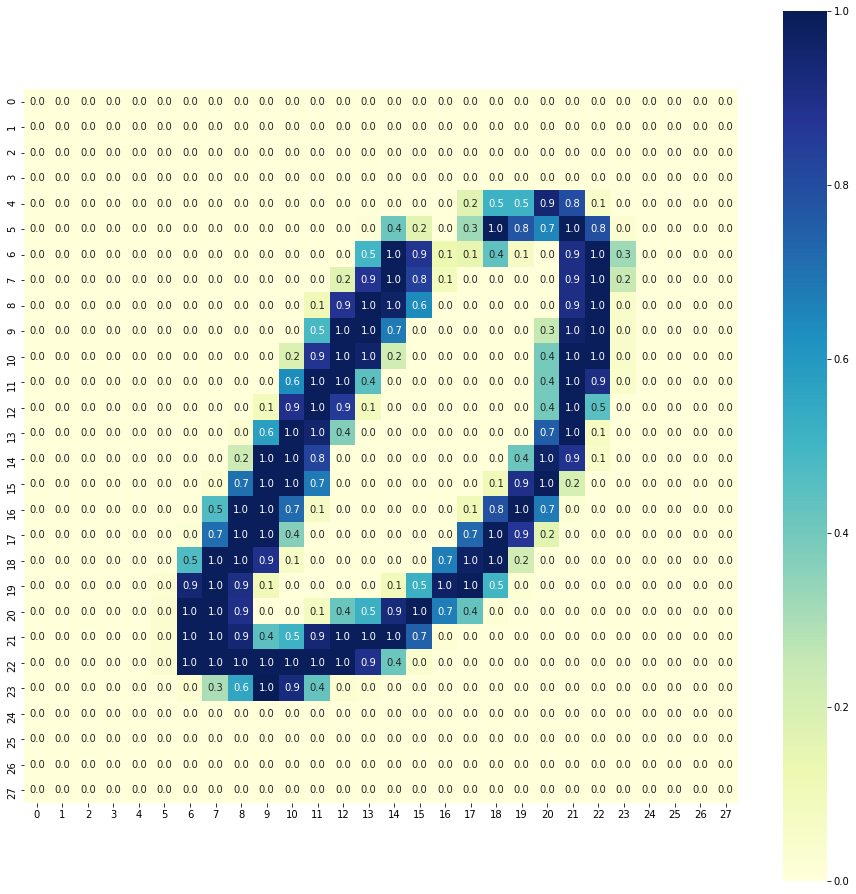


True digit: 1 (0.99998593), prediction: 1 (0.99998593)


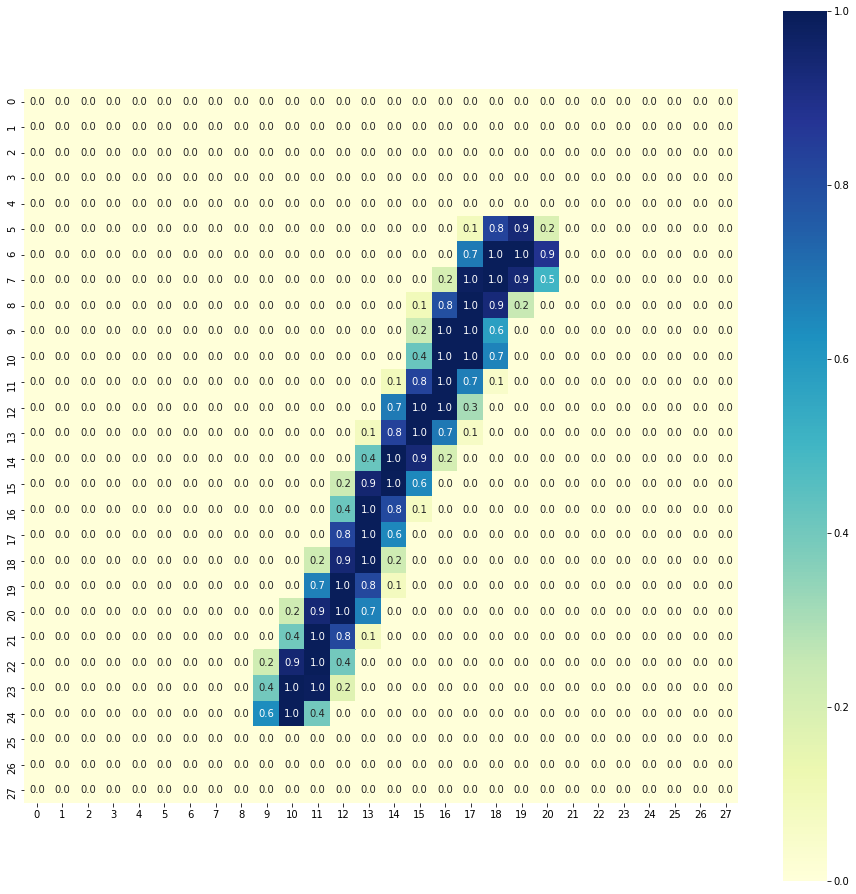


True digit: 2 (0.99997890), prediction: 2 (0.99997890)


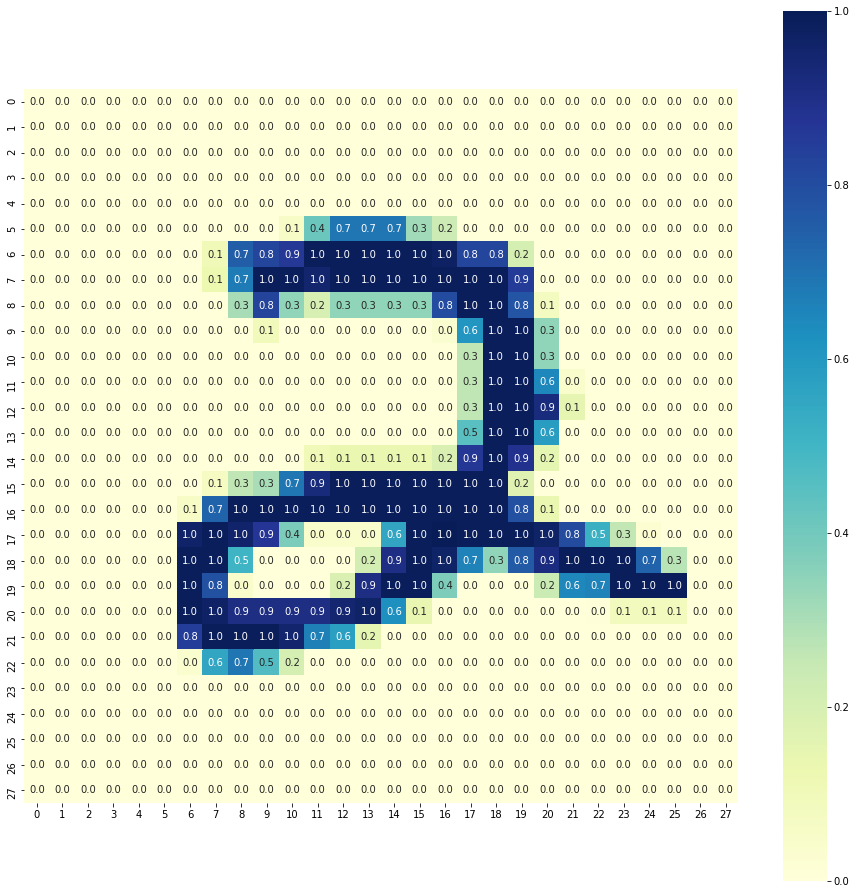

In [11]:
show_result(0, correct)
show_result(1, correct)
show_result(2, correct)

## Top-3 confusing examples


True digit: 5 (0.00000752), prediction: 6 (0.99997699)


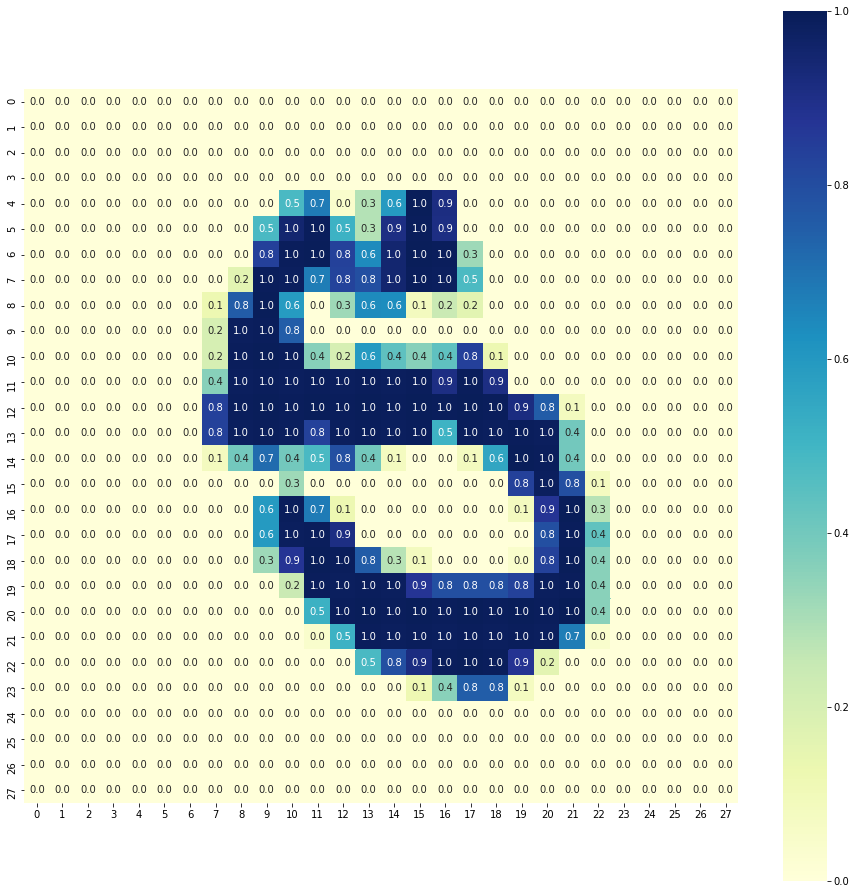


True digit: 4 (0.00004250), prediction: 6 (0.99993777)


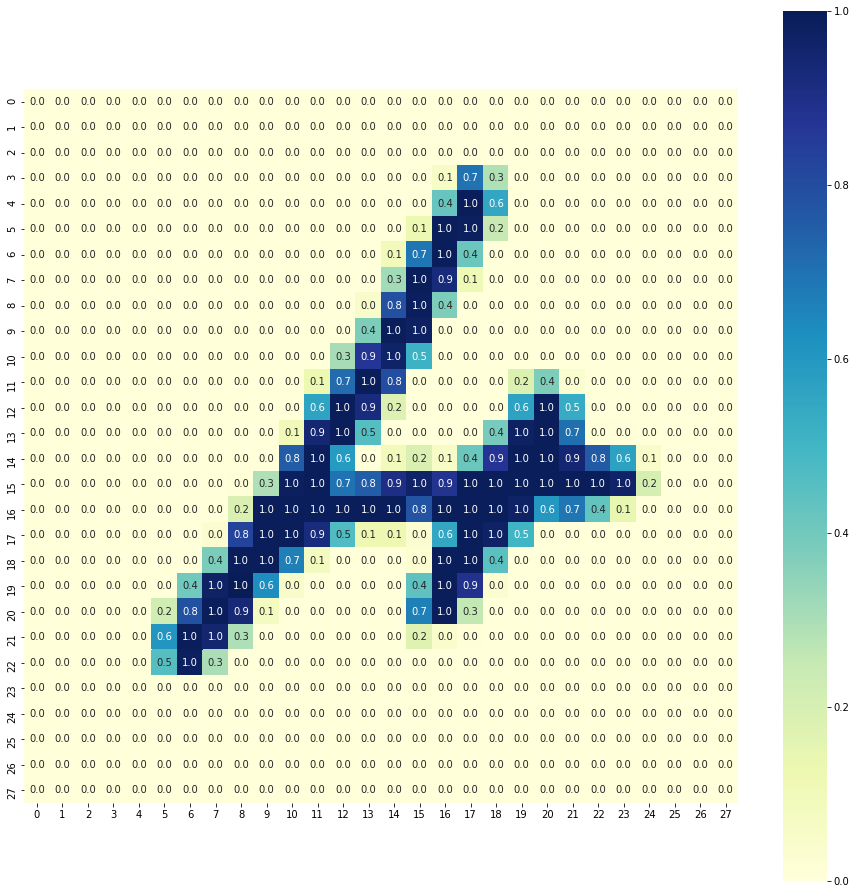


True digit: 7 (0.00000001), prediction: 2 (0.99993622)


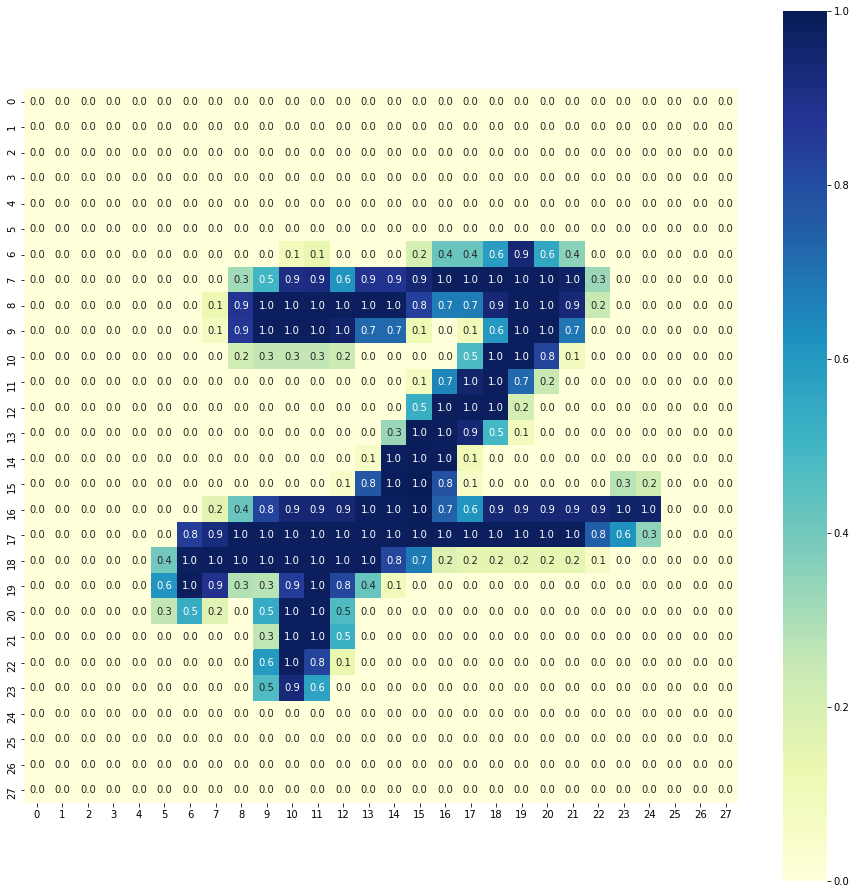

In [12]:
show_result(0, wrong)
show_result(1, wrong)
show_result(2, wrong)

## 4. Recognize your handwritten digits

Prepare three image files each of which presents a digit written by you. For each image, apply the MNIST model you trained, and show the probability estimate $\hat{y} \in \mathbb{R}^{10}$ (10-dimensional vector) for all possible digits as well as the image itself.

Please refer to [this notebook](https://colab.research.google.com/notebooks/io.ipynb) about how to upload a file to Google Colaboratory.

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image

# loader object
pixcel = 28
loader = transforms.Compose([
    transforms.Resize(pixcel),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()])

#
# function to display images
#
def disp_image(dir):
    plt.imshow(mpimg.imread(dir),cmap="gray")

#
# functions to predict numbers written by me
#
def convert_img_to_tensor(dir):
    img = Image.open(dir)
    img = loader(img).unsqueeze(1)
    return img.to(device, torch.float)

def predict_number(dir):
    img_t = convert_img_to_tensor(dir)
    res   = model(img_t)
    res_p = res.data.to('cpu')
    res_p = F.softmax(res_p, dim=1)

    print('probability: ')
    print(res_p, '\n')
    print('predicted number: ')
    print(res_p[0].argmax())

### Image #1

Write the code to show the image #1 here.

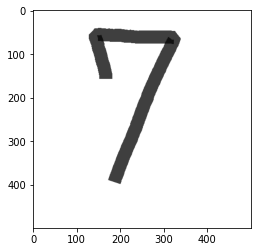

In [14]:
img1 = '7.png'
disp_image(img1)

Write the code to show the probability estimate $\hat{y} \in \mathbb{R}^{10}$ for the image.

In [15]:
predict_number(img1)

probability: 
tensor([[0.0204, 0.0121, 0.0794, 0.0641, 0.0973, 0.1299, 0.0136, 0.0444, 0.4097,
         0.1290]]) 

predicted number: 
tensor(8)


### Image #2

Write the code to show the image #2 here.

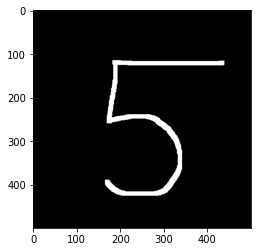

In [16]:
img2 = '5.png'
disp_image(img2)

Write the code to show the probability estimate $\hat{y} \in \mathbb{R}^{10}$ for the image.


In [17]:
predict_number(img2)

probability: 
tensor([[0.0462, 0.0215, 0.0409, 0.1275, 0.0559, 0.4384, 0.1161, 0.0087, 0.1011,
         0.0436]]) 

predicted number: 
tensor(5)


### Image #3

Write the code to show the image #3 here.

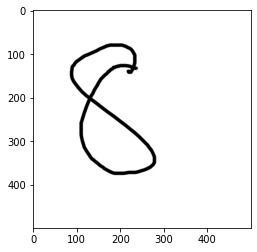

In [18]:
img3 = '8.png'
disp_image(img3)

Write the code to show the probability estimate $\hat{y} \in \mathbb{R}^{10}$ for the image.

In [19]:
predict_number(img3)

probability: 
tensor([[0.0089, 0.0030, 0.1282, 0.1143, 0.0075, 0.0059, 0.0013, 0.0057, 0.6746,
         0.0507]]) 

predicted number: 
tensor(8)
